In [1]:
library(dplyr)
library(broom)
library(lme4)
library(scales)
library(tidyverse)
library(stringr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
col_factor(): readr, scales
discard():    purrr, scales
expand():     tidyr, Matrix
filter():     dplyr, stats
lag():        dplyr, stats


In [2]:
full_experiment <- read.csv('exp_w_7_pilots_20180601.csv')

In [3]:
#full_experiment %>% group_by(StudyType, Scenario, genericCond) %>% summarize(count = n())

In [4]:
#compute labels (scenario + pilot/experiment)
full_experiment <- full_experiment %>% mutate(label=paste(StudyType, Scenario, sep='_'))

In [5]:
#compute the not_appropriate dependent variable
full_experiment <- full_experiment %>% mutate(not_app = ifelse((dv == 1 | dv == 2),1,0))

In [6]:
#group together pilot/scenario pairings which actually have teh same vignette text
#note that we do not have the pilots which were turned into full experiments (unless those data points are actually just marked as experiment)
#add the weights to the table
weights <- full_experiment %>% group_by(label) %>% summarize(count = n()) %>% mutate(weight=1/count)
full_experiment <- merge(full_experiment, weights, by='label', how='left')

In [7]:
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Checklist_exact', 'All_Checklist') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Checklist_pf', 'All_Checklist')
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Checklist', 'All_Checklist') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_DrugTeach_pf', 'All_DrugTeach')
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_DrugTeach', 'All_DrugTeach') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_DrugTeach', 'All_DrugTeach')

In [8]:
#group together all the checklist except for checklist_vary 

full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_AV_LeverAuto', 'Both_Autonomous Vehicles') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Autonomous Vehicles', 'Both_Autonomous Vehicles') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Genetic Testing', 'Both_GeneticTesting') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Charity1', 'All_Charity') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Charity2', 'All_Charity') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Charity', 'All_Charity') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Charity', 'All_Charity') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_GeneticTesting_ResultType', 'Both_GeneticTesting') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Teachers', 'All_Teachers') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Education', 'All_Teachers') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Drug', 'All_Drug') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Drug', 'All_Drug') 

In [9]:
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Funds1', 'All_Retirement') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Funds2', 'All_Retirement') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Funds', 'All_Retirement') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Retirement', 'All_Retirement') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Recruit', 'All_Recruit') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Recruit', 'All_Recruit') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Pilot_Welfare', 'All_Basic_Income') 
full_experiment$label <- str_replace_all(full_experiment$label, 'Experiment_Basic Income', 'All_Basic_Income') 

In [10]:
full_experiment %>% group_by(label) %>% summarize(count = n())

label,count
All_Basic_Income,423
All_Charity,403
All_Checklist,1640
All_Checklist_vary,401
All_Drug,390
All_DrugTeach,1117
All_Recruit,383
All_Retirement,388
All_Teachers,390
Both_Autonomous Vehicles,592


In [11]:
full_experiment %>% nrow()

[1] 7243

In [12]:
#now instead of both A and B, we only want the lower one
abs <- full_experiment %>% group_by(label, genericCond) %>% summarize(mean = mean(dv)) %>% filter(genericCond=='AB')
lower <- full_experiment %>% group_by(label, genericCond) %>% summarize(mean = mean(dv)) %>% filter(genericCond!='AB') %>% group_by(label) %>% filter(mean == min(mean)) 
selected <- rbind(abs, lower) %>% select(-mean)
lower_experiment <- inner_join(selected, full_experiment) %>% select(label, genericCond, dv, not_app)
lower_experiment <- lower_experiment %>% mutate(condition = ifelse(genericCond == 'AB', 'Treatment', 'Policy')) %>% select( - genericCond)

Joining, by = c("label", "genericCond")


In [13]:
lower_experiment %>% nrow()

[1] 5062

In [14]:
lower_experiment %>% group_by(label, condition) %>% summarize(avg_score = mean(dv))

label,condition,avg_score
All_Basic_Income,Policy,3.735294
All_Basic_Income,Treatment,3.474684
All_Charity,Policy,3.575758
All_Charity,Treatment,3.268657
All_Checklist,Policy,3.752688
All_Checklist,Treatment,2.902728
All_Checklist_vary,Policy,3.849057
All_Checklist_vary,Treatment,3.494792
All_Drug,Policy,4.374046
All_Drug,Treatment,3.201493


In [15]:
hlm_model <- lmer(dv ~ 1 + condition + (condition|label), data=lower_experiment)

In [16]:
hlm_model

Linear mixed model fit by REML ['lmerMod']
Formula: dv ~ 1 + condition + (condition | label)
   Data: lower_experiment
REML criterion at convergence: 17061.67
Random effects:
 Groups   Name               Std.Dev. Corr 
 label    (Intercept)        0.2725        
          conditionTreatment 0.2858   -0.78
 Residual                    1.2981        
Number of obs: 5062, groups:  label, 18
Fixed Effects:
       (Intercept)  conditionTreatment  
            3.7813             -0.4423  

In [17]:
ranef(hlm_model)

$label
                              (Intercept) conditionTreatment
All_Basic_Income              -0.03307101         0.13310511
All_Charity                   -0.16946813         0.11044464
All_Checklist                 -0.03676966        -0.37403330
All_Checklist_vary             0.06416802         0.06034671
All_Drug                       0.49510881        -0.56831378
All_DrugTeach                  0.01701025         0.04474286
All_Recruit                    0.30942722        -0.05356317
All_Retirement                 0.07326974        -0.19736711
All_Teachers                  -0.05712953         0.01295034
Both_Autonomous Vehicles       0.24832756        -0.13582367
Both_GeneticTesting            0.35222811        -0.24435954
Pilot_GeneticTesting_Disease  -0.41056801         0.31619050
Pilot_Hours                    0.07238378         0.10261755
Pilot_Income                  -0.03248598        -0.05446054
Pilot_OnlineDating_Percent    -0.24359901         0.27971011
Pilot_OnlineDatin

In [18]:
foobar = data.frame(tidy(hlm_model)) %>% head(2) %>% select(term, estimate) %>% spread(term, estimate)
row.names(foobar) = 'Fixed Effects'
foobar <- foobar %>% rename(Treatment=conditionTreatment)
hlm_table_paper <- data.frame(ranef(hlm_model)$label)
hlm_table_paper <- rownames_to_column(hlm_table_paper)
hlm_table_paper <- hlm_table_paper %>% rename(Scenario=rowname) %>% rename(Intercept=X.Intercept.) %>% rename(Treatment=conditionTreatment)
foobar
hlm_table_paper

,(Intercept),Treatment
Fixed Effects,3.781326,-0.4423172


Scenario,Intercept,Treatment
All_Basic_Income,-0.03307101,0.13310511
All_Charity,-0.16946813,0.11044464
All_Checklist,-0.03676966,-0.37403330
All_Checklist_vary,0.06416802,0.06034671
All_Drug,0.49510881,-0.56831378
All_DrugTeach,0.01701025,0.04474286
All_Recruit,0.30942722,-0.05356317
All_Retirement,0.07326974,-0.19736711
All_Teachers,-0.05712953,0.01295034
Both_Autonomous Vehicles,0.24832756,-0.13582367


In [19]:
tidy(hlm_model)

term,estimate,std.error,statistic,group
(Intercept),3.7813259,0.07414971,50.995828,fixed
conditionTreatment,-0.4423172,0.08310293,-5.322522,fixed
sd_(Intercept).label,0.2724621,NA,NA,label
sd_conditionTreatment.label,0.2857679,NA,NA,label
cor_(Intercept).conditionTreatment.label,-0.7820959,NA,NA,label
sd_Observation.Residual,1.2980975,NA,NA,Residual


Saving 7 x 7 in image


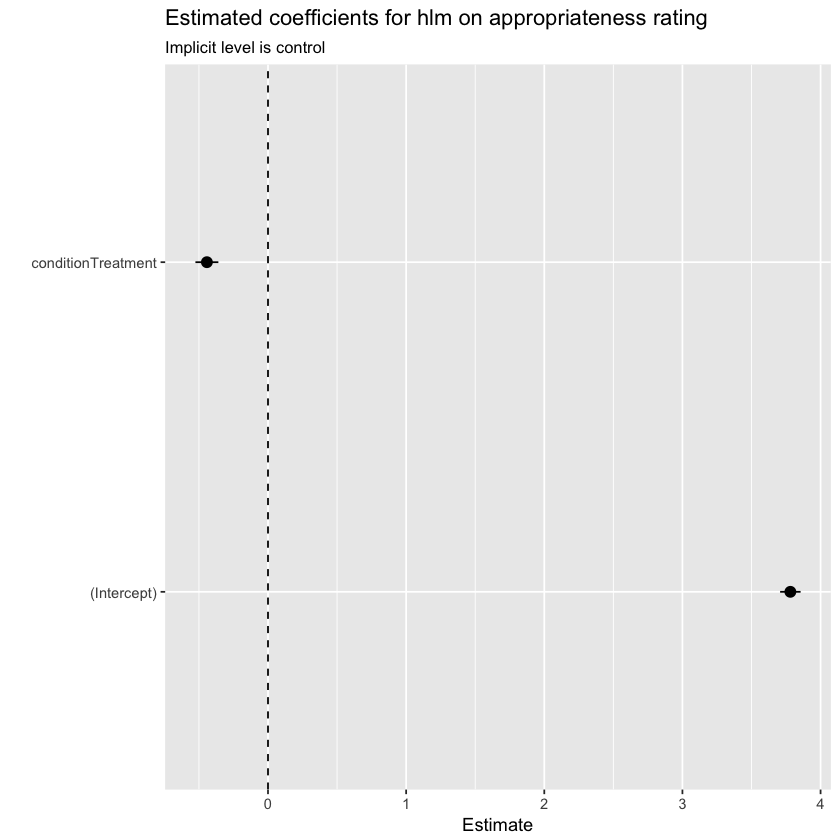

In [20]:
tidy(hlm_model) %>%
  filter(!grepl('(^(sd_|cor))', term)) %>%
  ggplot(aes(x = term, y = estimate)) +
  geom_pointrange(aes(ymin = estimate -  std.error, ymax = estimate + std.error)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Estimated coefficients for hlm on appropriateness rating",
       subtitle = "Implicit level is control",
       x = "",
       y = "Estimate") +
  coord_flip() 
ggsave('hlm_ab_effect.pdf')

Saving 7 x 7 in image


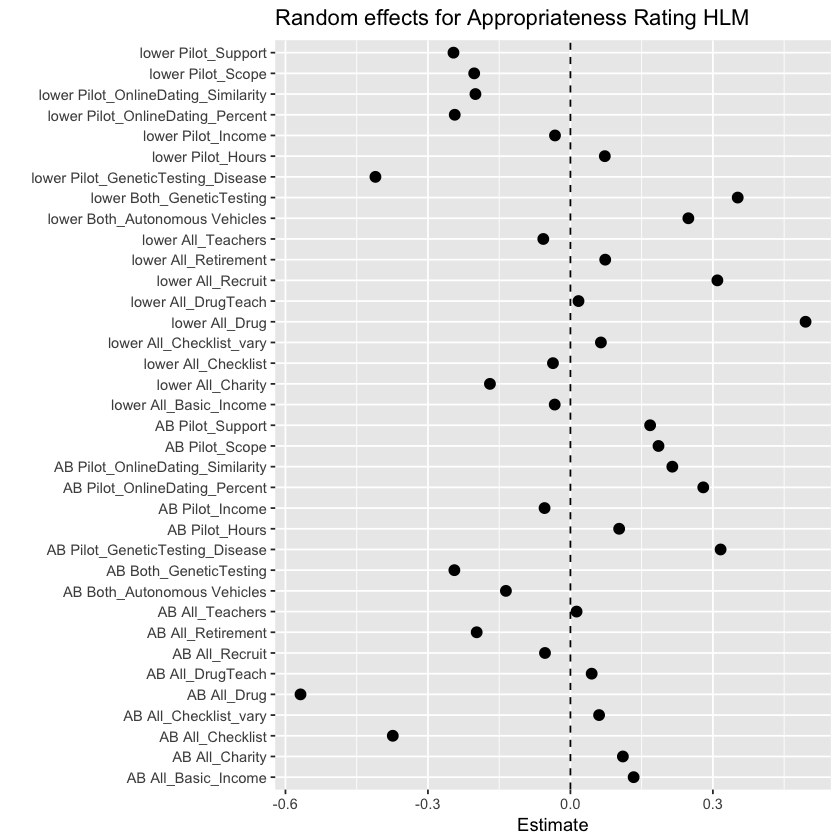

In [21]:
ranefs <- data.frame(ranef(hlm_model))
ranefs <- ranefs %>% mutate(condition = ifelse(term=='(Intercept)', 'lower', 'AB'))
ranefs <- ranefs %>% mutate(label=paste(condition, grp))
ranefs %>%
  ggplot(aes(x = label, y = condval)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
geom_pointrange(aes(ymin = condval - .0001, ymax = condval + .0001)) +
  labs(title = "Random effects for Appropriateness Rating HLM",
       x = "",
       y = "Estimate") +
  coord_flip()
ggsave('hlm_random_effects.pdf')

In [22]:
#make the other hlm model for binary inappropriate dv
hlm_model <- lmer(not_app ~ 1 + condition + (condition|label), data=lower_experiment)

In [23]:
tidy(hlm_model)

term,estimate,std.error,statistic,group
(Intercept),0.19671802,0.01709903,11.50463,fixed
conditionTreatment,0.11300648,0.02407846,4.69326,fixed
sd_(Intercept).label,0.05373279,NA,NA,label
sd_conditionTreatment.label,0.07701072,NA,NA,label
cor_(Intercept).conditionTreatment.label,-0.57549699,NA,NA,label
sd_Observation.Residual,0.43468171,NA,NA,Residual


In [24]:
foobar = data.frame(tidy(hlm_model)) %>% head(2) %>% select(term, estimate) %>% spread(term, estimate)
row.names(foobar) = 'Fixed Effects'
foobar <- foobar %>% rename(Treatment=conditionTreatment)
hlm_table_paper <- data.frame(ranef(hlm_model)$label)
hlm_table_paper <- rownames_to_column(hlm_table_paper)
hlm_table_paper <- hlm_table_paper %>% rename(Scenario=rowname) %>% rename(Intercept=X.Intercept.) %>% rename(Treatment=conditionTreatment)

Saving 7 x 7 in image


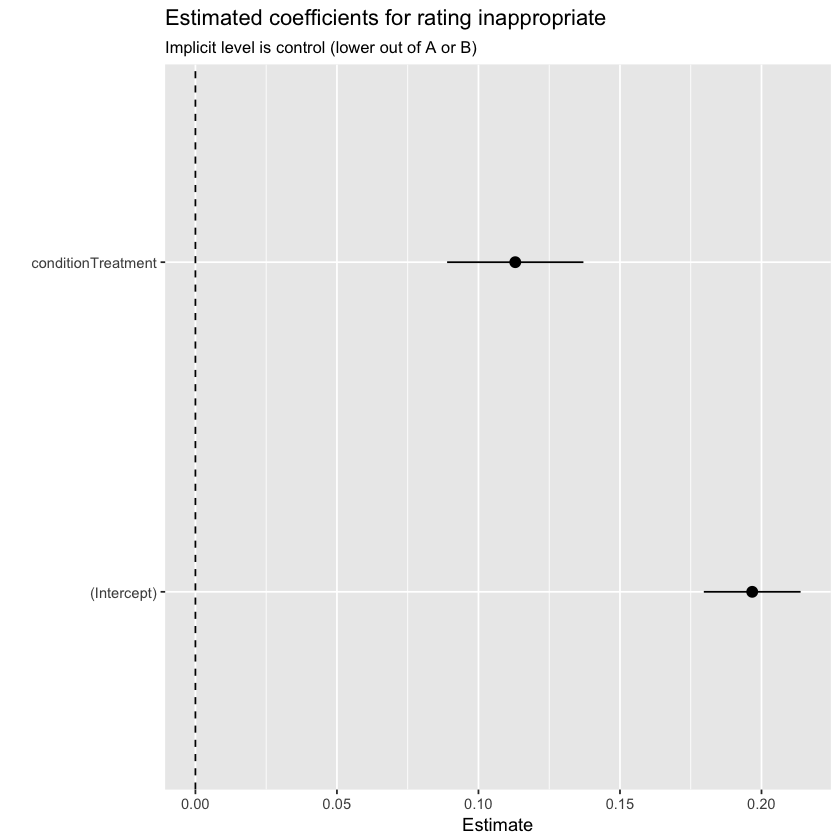

In [25]:
tidy(hlm_model) %>%
  filter(!grepl('(^(sd_|cor))', term)) %>%
  ggplot(aes(x = term, y = estimate)) +
  geom_pointrange(aes(ymin = estimate -  std.error, ymax = estimate + std.error)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
  labs(title = "Estimated coefficients for rating inappropriate",
       subtitle = "Implicit level is control (lower out of A or B)",
       x = "",
       y = "Estimate") +
  coord_flip() 
ggsave('hlm_ab_effect_inapp.pdf')

In [26]:
ranefs <- data.frame(ranef(hlm_model))
ranefs <- ranefs %>% mutate(condition = ifelse(term=='(Intercept)', 'lower', 'AB'))
ranefs <- ranefs %>% mutate(label=paste(condition, grp))

Saving 7 x 7 in image


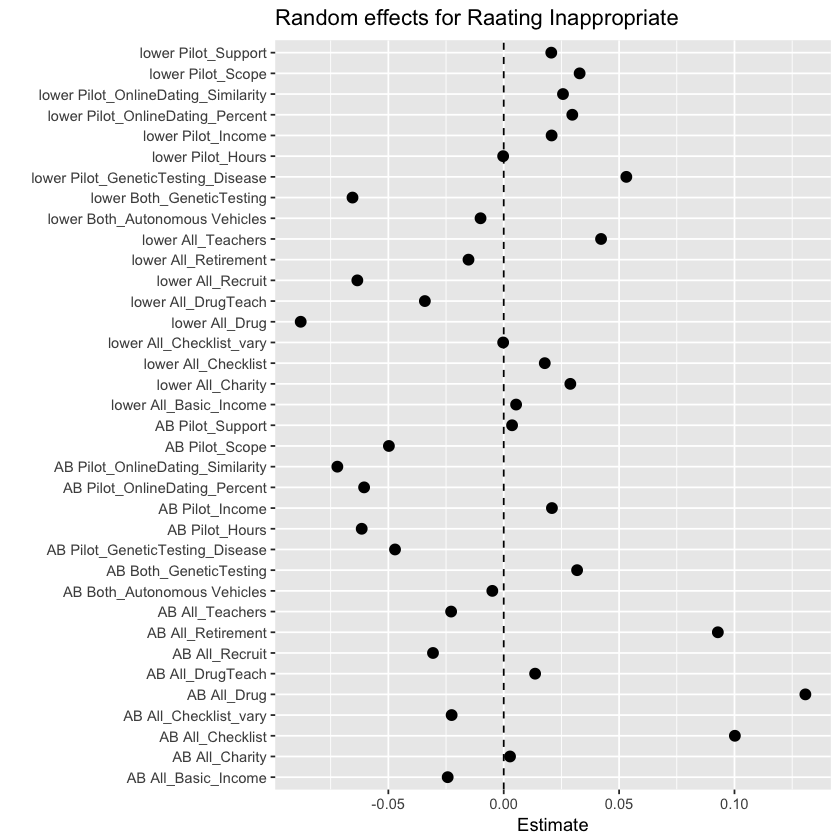

In [27]:
ranefs %>%
  ggplot(aes(x = label, y = condval)) +
  geom_hline(yintercept = 0, linetype = "dashed") +
geom_pointrange(aes(ymin = condval - .0001, ymax = condval + .0001)) +
  labs(title = "Random effects for Raating Inappropriate",
       x = "",
       y = "Estimate") +
  coord_flip()
ggsave('hlm_random_effects_inapp.pdf')